- p: The order of the auto-regressive (AR) model (i.e., the number of lag observations). A time series is considered AR when previous values in the time series are very predictive of later values. An AR process will show a very gradual decrease in the ACF plot.
- d: The degree of differencing.
- q: The order of the moving average (MA) model. This is essentially the size of the “window” function over your time series data. An MA process is a linear combination of past errors.

In [34]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from pmdarima.arima import auto_arima
import warnings
warnings.filterwarnings('ignore')
import pickle
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

import panel as pn
#from xgboost import XGBRegressor
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

## load data

In [35]:

df_passenger = pd.read_csv('https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv'
                 ,parse_dates=True
                 ,index_col="Month")
df_passenger['#Passengers'] = pd.to_numeric(df_passenger['#Passengers'],downcast='integer')
df_passenger

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   #Passengers  144 non-null    int16
dtypes: int16(1)
memory usage: 1.4 KB
None


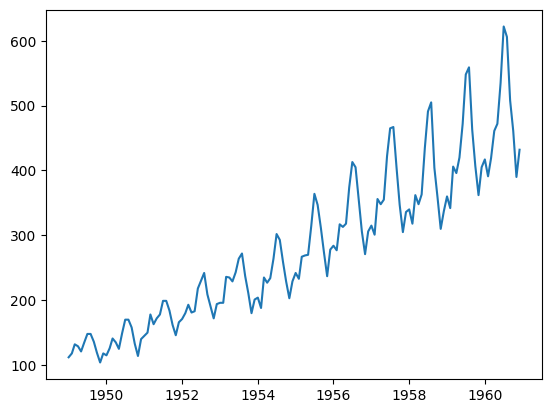

In [36]:
print(plt.plot(df_passenger))
print(df_passenger.info())


## Fill date gaps 

In [37]:
date_new= df_passenger['#Passengers'].resample('M').mean()

In [38]:
df_passenger['Month']=date_new

In [39]:
df=date_new.to_frame()
df

,#Passengers
Month,
1949-01-31,112.0
1949-02-28,118.0
1949-03-31,132.0
1949-04-30,129.0
1949-05-31,121.0
...,...
1960-08-31,606.0
1960-09-30,508.0
1960-10-31,461.0


In [40]:
# ADF Test
# Function to print out results in customised manner
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
# Call the function and run the test

adf_test(df['#Passengers'])

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


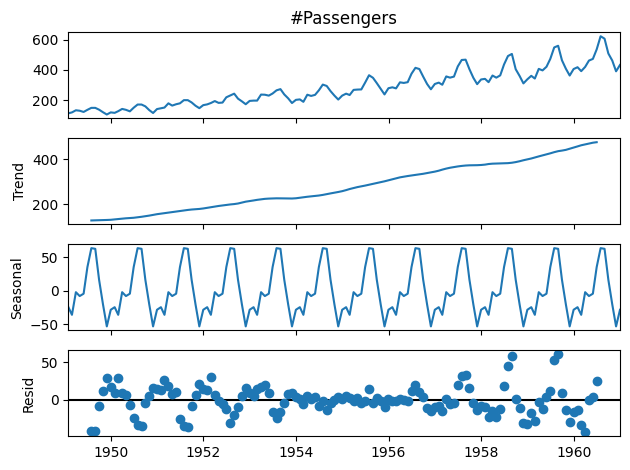

In [41]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['#Passengers'], model='additive')  # จะใช้ model = 'add'ก็ได้เหมือนกัน
result.plot();

In [42]:
# Define better plot function
def plotSeasonal(result, axs):
  result.observed.plot(ax = axs[0], legend = False)
  axs[0].set_ylabel('Observed')
  result.trend.plot(ax = axs[1], legend = False)
  axs[1].set_ylabel('Trend')
  result.seasonal.plot(ax = axs[2], legend = False)
  axs[2].set_ylabel('Seasonal')
  result.resid.plot(ax = axs[3], legend = False)
  axs[3].set_ylabel('Residual')
  return

In [43]:
#df['Month']=pd.to_datetime(df['Month'].astype(str), format='%Y-%m-%d')
df=df.sort_values(by=['Month'])

In [44]:
df

,#Passengers
Month,
1949-01-31,112.0
1949-02-28,118.0
1949-03-31,132.0
1949-04-30,129.0
1949-05-31,121.0
...,...
1960-08-31,606.0
1960-09-30,508.0
1960-10-31,461.0


In [45]:
df.dtypes

#Passengers    float64
dtype: object

In [46]:
#df["#Passengers"]=str(df["#Passengers"])
#df.dtypes

## plot the data

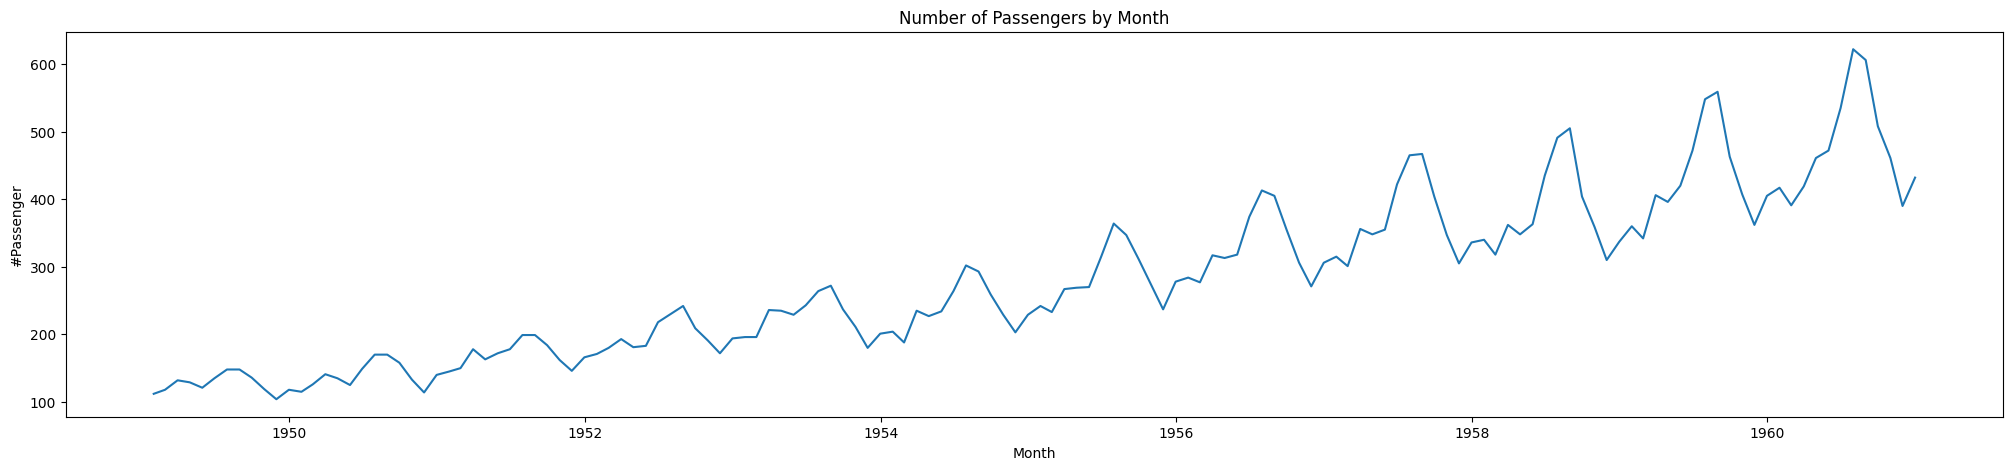

In [47]:
plt.figure(figsize=(25,5))
plt.title("Number of Passengers by Month")
plt.xlabel('Month')
plt.ylabel('#Passenger')
plt.plot(df)
plt.show()

## <center>ARIMA Model Selection w/ Auto-ARIMA</center>


## fill values with mean values 

In [48]:
df.isnull().sum()

#Passengers    0
dtype: int64

In [49]:
df['#Passengers'].fillna(value=df['#Passengers'].mean(), inplace=True)

In [50]:
df.isnull().sum()

#Passengers    0
dtype: int64

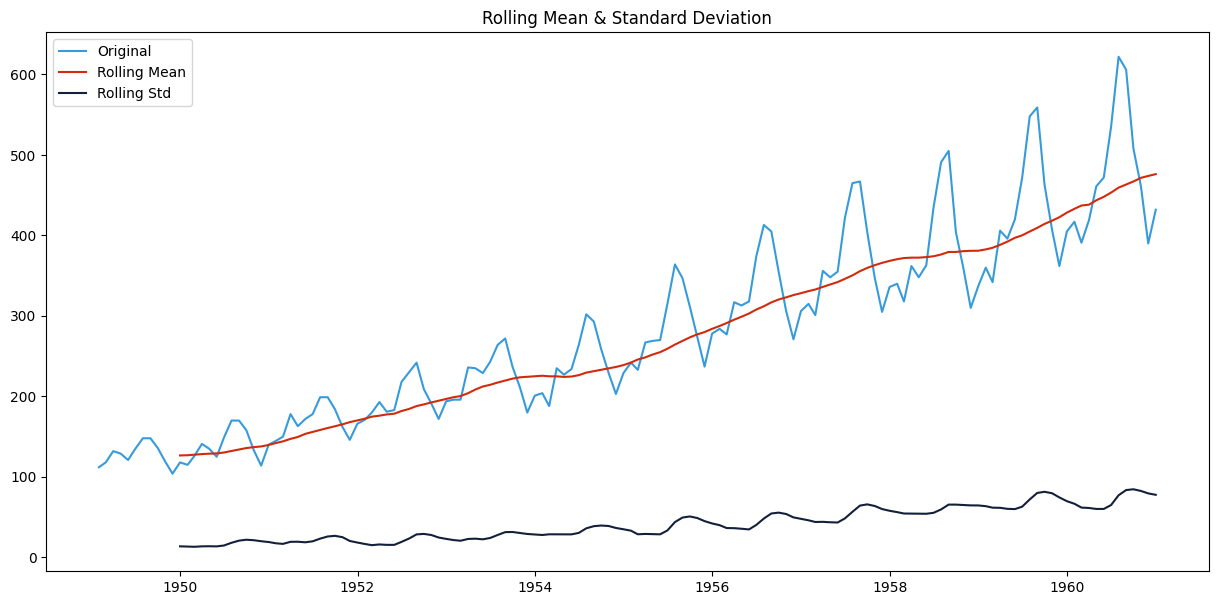

In [51]:
#Determine rolling statistics
df["rolling_avg"] = df["#Passengers"].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
df["rolling_std"] = df["#Passengers"].rolling(window=12).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df["#Passengers"], color='#379BDB', label='Original')
plt.plot(df["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(df["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

## ARIMA 

In [52]:
#Standard ARIMA Model
ARIMA_model = auto_arima(df['#Passengers'], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=True, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1412.973, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2057.847, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1410.569, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1417.450, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1411.319, Time=0.13 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1411.135, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1413.093, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1408.249, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1409.748, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1413.639, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1408.287, T

In [53]:
file_name = "ARIMA_model_reg.pkl"

# save
pickle.dump(ARIMA_model, open(file_name, "wb"))

# load
ARIMA_model = pickle.load(open(file_name, "rb"))

In [54]:
#ARIMA_model = sm.tsa.arima.ARIMA((df['Parcel']),  order=(3,0,3))

(ARIMA_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -699.125
Date:                Fri, 09 Aug 2024   AIC                           1408.249
Time:                        18:31:25   BIC                           1423.098
Sample:                    01-31-1949   HQIC                          1414.283
                         - 12-31-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     19.6007     12.051      1.627      0.104      -4.018      43.219
ar.L1          0.4990      0.131      3.822      0.000       0.243       0.755
ar.L2          0.4314      0.124      3.466      0.001       0.187       0.675
ma.L1          0.8565      0.081     10.540      0.000       0.697       1.016
sigma2       942.2489    107.314      8.780      0.000     731.917    1152.581
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                 0.89
Prob(Q):                              0.63   Prob(JB):                         0.64
Heteroskedasticity (H):               6.30   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

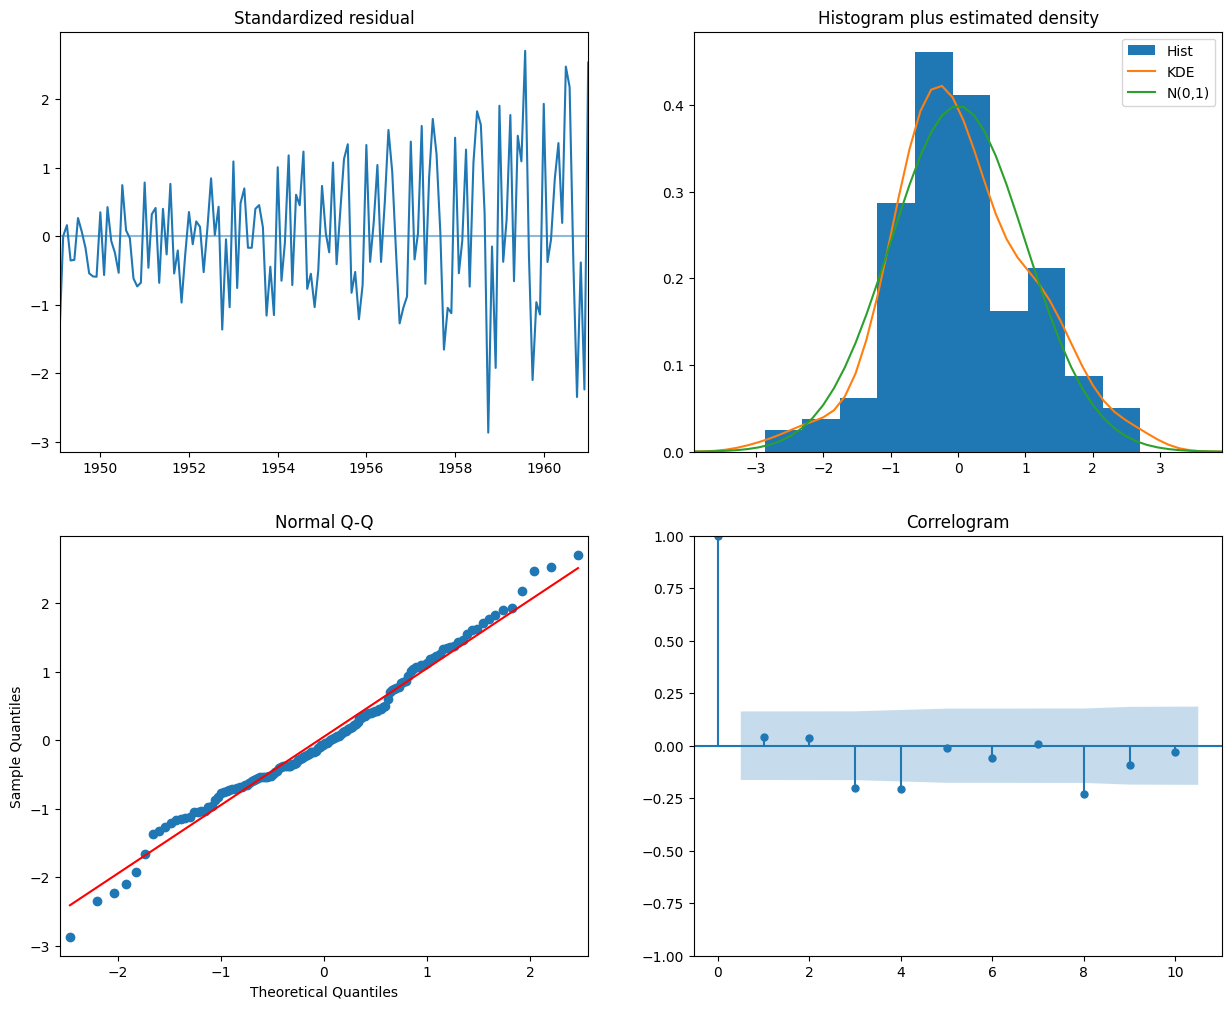

In [55]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

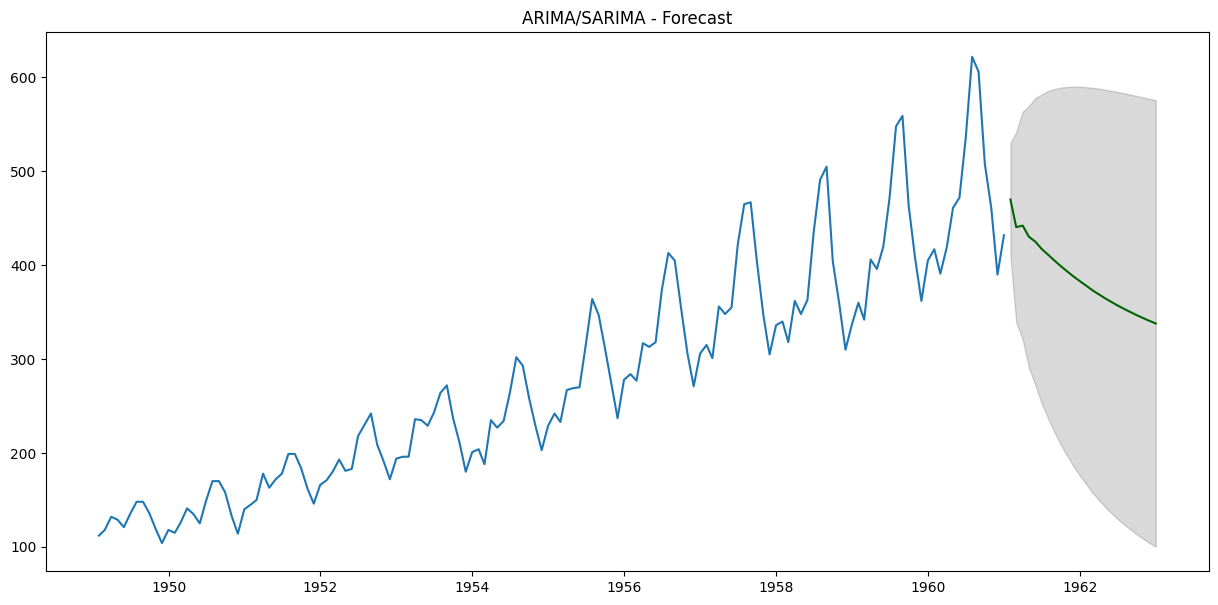

In [56]:
def forecast(ARIMA_model, periods=24):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    #pred = ARIMA_model.predict(n_periods=len(df["#y"]),dynamic=True)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='M')
    
    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df["#Passengers"], color='#1f76b4')
    #plt.plot(pred, color='yellow')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast")
    plt.show()

forecast(ARIMA_model)

## <center>SARIMA Model Selection</center>


In [57]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(df["#Passengers"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=12, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1022.896, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.08 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1019.239, Time=0.13 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.95 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1020.493, Time=0.20 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=0.10 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1021.120, Time=0.18 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1021.032, Time=0.24 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1019.178, Time=0.14 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1020.425, Time=0.06 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=0.81 sec
 ARIMA(0,1,1)(1,1,1)[12]     

In [58]:
file_name = "SARIMA_model_reg.pkl"

# save
pickle.dump(SARIMA_model, open(file_name, "wb"))

# load
SARIMA_model = pickle.load(open(file_name, "rb"))

In [59]:
(SARIMA_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -505.589
Date:                             Fri, 09 Aug 2024   AIC                           1019.178
Time:                                     18:31:30   BIC                           1030.679
Sample:                                 01-31-1949   HQIC                          1023.851
                                      - 12-31-1960                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3634      0.074     -4.945      0.000      -0.508      -0.219
ar.S.L12      -0.1239      0.090     -1.372      0.170      -0.301       0.053
ar.S.L24       0.1911      0.107      1.783      0.075      -0.019       0.401
sigma2       130.4480     15.527      8.402      0.000     100.016     160.880
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 4.59
Prob(Q):                              0.92   Prob(JB):                         0.10
Heteroskedasticity (H):               2.70   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

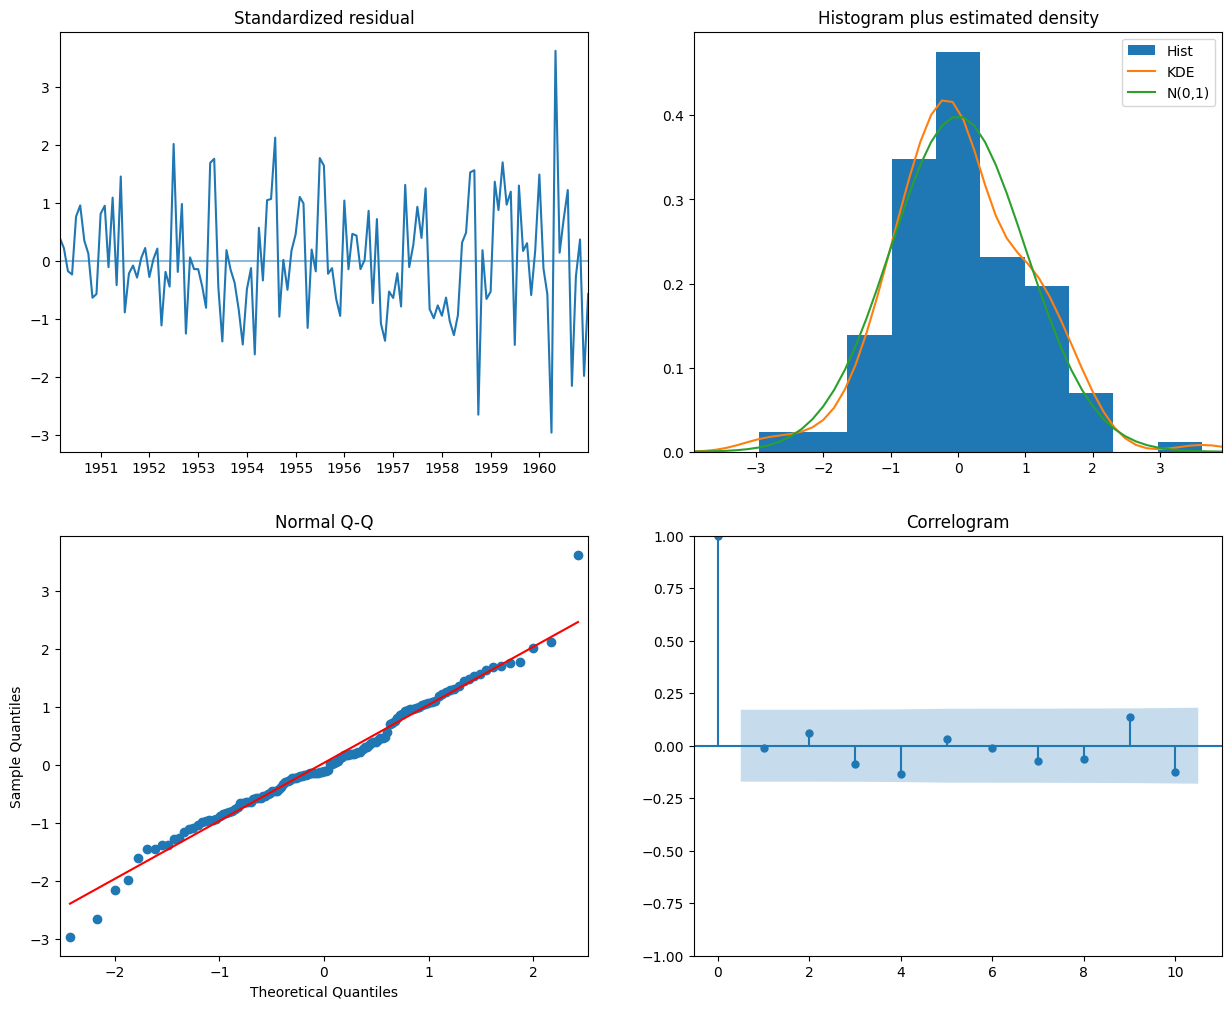

In [60]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

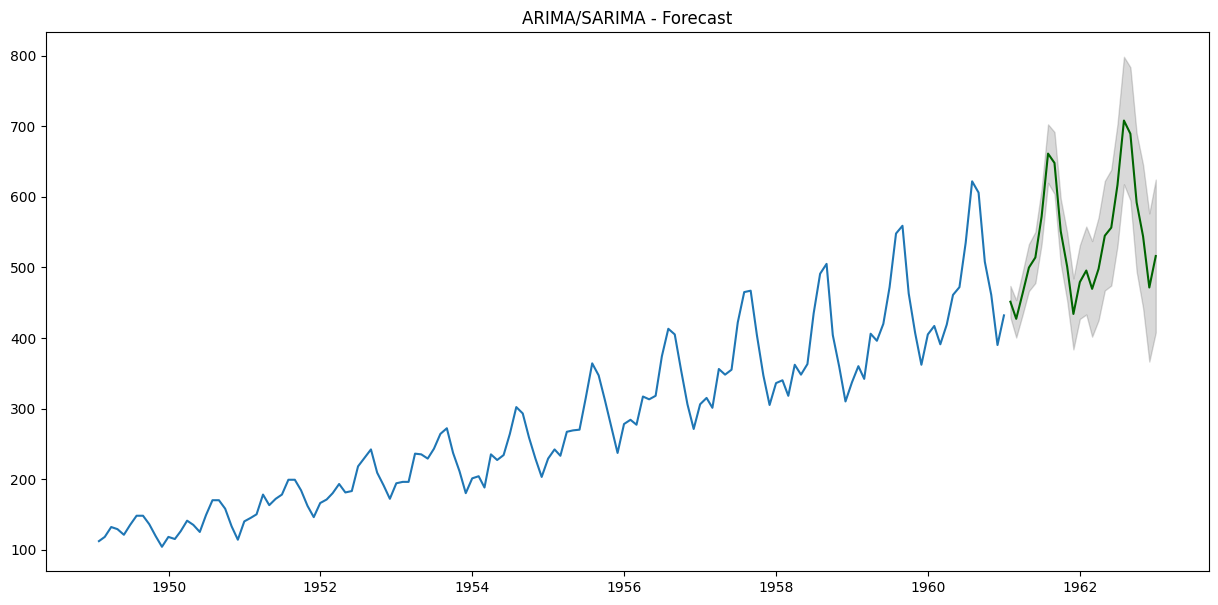

In [61]:
forecast(SARIMA_model)

## <center>SARIMAX Model Selection</center>



In [62]:
df['month_index'] = df.index.month
df['month_index']

Month
1949-01-31     1
1949-02-28     2
1949-03-31     3
1949-04-30     4
1949-05-31     5
              ..
1960-08-31     8
1960-09-30     9
1960-10-31    10
1960-11-30    11
1960-12-31    12
Freq: ME, Name: month_index, Length: 144, dtype: int32

In [63]:
#adding exogenous variable
df['month_index'] = df.index.month

# SARIMAX Model
SARIMAX_model = pm.auto_arima(df[['#Passengers']], exogenous=df[['month_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, 
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

SARIMAX_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1022.896, Time=0.12 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.11 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1019.239, Time=0.13 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.95 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1020.493, Time=0.17 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=0.09 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1021.120, Time=0.18 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1021.032, Time=0.24 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1019.178, Time=0.14 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1020.425, Time=0.06 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=0.79 sec
 ARIMA(0,1,1)(1,1,1)[12]     

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -505.589
Date:                             Fri, 09 Aug 2024   AIC                           1019.178
Time:                                     18:31:34   BIC                           1030.679
Sample:                                 01-31-1949   HQIC                          1023.851
                                      - 12-31-1960                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3634      0.074     -4.945      0.000      -0.508      -0.219
ar.S.L12      -0.1239      0.090     -1.372      0.170      -0.301       0.053
ar.S.L24       0.1911      0.107      1.783      0.075      -0.019       0.401
sigma2       130.4480     15.527      8.402      0.000     100.016     160.880
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 4.59
Prob(Q):                              0.92   Prob(JB):                         0.10
Heteroskedasticity (H):               2.70   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [64]:
file_name = "SARIMAX_model_reg.pkl"

# save
pickle.dump(SARIMAX_model, open(file_name, "wb"))

# load
SARIMAX_model = pickle.load(open(file_name, "rb"))

#y_pred_load=model_loaded.predict(X)

In [65]:
SARIMAX_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -505.589
Date:                             Fri, 09 Aug 2024   AIC                           1019.178
Time:                                     18:31:34   BIC                           1030.679
Sample:                                 01-31-1949   HQIC                          1023.851
                                      - 12-31-1960                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3634      0.074     -4.945      0.000      -0.508      -0.219
ar.S.L12      -0.1239      0.090     -1.372      0.170      -0.301       0.053
ar.S.L24       0.1911      0.107      1.783      0.075      -0.019       0.401
sigma2       130.4480     15.527      8.402      0.000     100.016     160.880
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 4.59
Prob(Q):                              0.92   Prob(JB):                         0.10
Heteroskedasticity (H):               2.70   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We can see that similar to the SARIMA model we are getting some pretty good-looking predictions and the width of the forecasted confidence interval has decreased. This means that the model is more certain of its predictions.

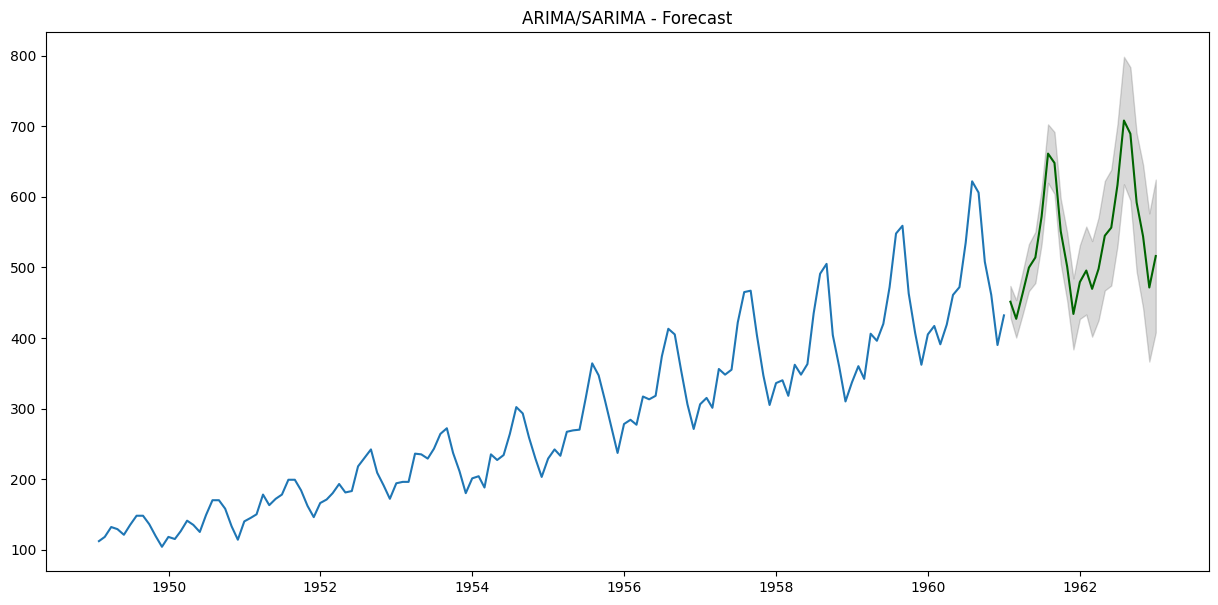

In [66]:
forecast(SARIMAX_model)